In [1]:
# Imports de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns      
import missingno as msno
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures

from apafib import load_medical_costs  
from sklearn.model_selection import train_test_split
from scipy import stats
from matplotlib.lines import Line2D

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Definiciones
RND = 16 

columns = ['age','sex','bmi','children','smoker','region','charges']
columns_no_target = ['age','sex','bmi','children','smoker','region']
numerical_columns = ['age', 'children', 'bmi']
numerical_columns_with_target = ['age', 'children', 'bmi', 'charges']
categorical_columns = ['sex', 'smoker', 'region']   
target = 'charges'

sns.set(style="whitegrid", font_scale=1.05)

# Funciones auxiliares
def format_pval(p):
    """Formatea p-value: decimal si p >= 1e-3, si no en notación mantisa*10^{exp} (LaTeX)."""
    if p == 0:
        return r"$0$"
    exp = int(np.floor(np.log10(p)))
    if exp >= -3:
        return f"{p:.4f}"                # p mostrado como decimal (4 decimales)
    else:
        mant = p / (10.0**exp)
        # devolver string LaTeX, por ejemplo: $1.94\times10^{-19}$
        return rf"${mant:.2f}\times10^{{{exp}}}$"
    

from time import time
from datetime import timedelta
init_time = time()


# quitar warnings:
import warnings
warnings.filterwarnings("ignore", message="findfont:.*")

In [2]:
matches = pd.read_csv('./data/atp_matches_cleaned.csv')
matches.head()

,tourney_name,surface,draw_size,tourney_date,match_num,best_of,round,year,month,tourney_points,...,player2_winrate,player2_ytd_wins,player2_ytd_losses,player2_ytd_winrate,player1_last10_wins,player1_last10_losses,player1_last10_winrate,player2_last10_wins,player2_last10_losses,player2_last10_winrate
0,Brisbane,Hard,32,20110102,1,3,R32,2011,1,250,...,0.0,0,0,0.0,0,0,0.0,0,0,0.0
1,Brisbane,Hard,32,20110102,2,3,R32,2011,1,250,...,0.0,0,0,0.0,0,0,0.0,0,0,0.0
2,Brisbane,Hard,32,20110102,3,3,R32,2011,1,250,...,0.0,0,0,0.0,0,0,0.0,0,0,0.0
3,Brisbane,Hard,32,20110102,4,3,R32,2011,1,250,...,0.0,0,0,0.0,0,0,0.0,0,0,0.0
4,Brisbane,Hard,32,20110102,5,3,R32,2011,1,250,...,0.0,0,0,0.0,0,0,0.0,0,0,0.0


División 70% / 30%

In [3]:
matches_train, matches_test = train_test_split(matches, test_size=0.3, random_state=RND)


## Creación de la variable objetivo (Target)

El dataset ya contiene la columna `player1_wins` que indica si el jugador 1 ganó el partido (1) o perdió (0).

**Decisión de nomenclatura:**
- Mantenemos la estructura `player_1` vs `player_2` (estándar en deportes)
- Renombramos `player1_wins` → `winner` para mayor claridad
- **Interpretación:**
  - `winner = 1` → player_1 ganó el partido
  - `winner = 0` → player_2 ganó el partido

Esta variable será nuestro **target** para los modelos de clasificación.

In [4]:
# Verificar que la columna player1_wins existe
print("🔍 Verificando columna objetivo...")
if 'player1_wins' in matches.columns:
    print("✅ La columna 'player1_wins' existe en el dataset")
    
    # Renombrar para mayor claridad conceptual
    matches.rename(columns={'player1_wins': 'winner'}, inplace=True)
    matches_train.rename(columns={'player1_wins': 'winner'}, inplace=True)
    matches_test.rename(columns={'player1_wins': 'winner'}, inplace=True)
    
    print("✅ Columna renombrada: 'player1_wins' → 'winner'")
    print(f"\n📊 Balance del target:")
    print(f"   winner = 1 (player_1 ganó): {matches_train['winner'].sum():,} partidos ({matches_train['winner'].mean()*100:.2f}%)")
    print(f"   winner = 0 (player_2 ganó): {(~matches_train['winner'].astype(bool)).sum():,} partidos ({(1-matches_train['winner'].mean())*100:.2f}%)")
else:
    print("❌ ERROR: La columna 'player1_wins' no se encuentra en el dataset")
    print(f"Columnas disponibles: {matches.columns.tolist()}")

🔍 Verificando columna objetivo...
✅ La columna 'player1_wins' existe en el dataset
✅ Columna renombrada: 'player1_wins' → 'winner'

📊 Balance del target:
   winner = 1 (player_1 ganó): 13,694 partidos (49.49%)
   winner = 0 (player_2 ganó): 13,979 partidos (50.51%)


In [5]:
# Visualizar ejemplos de partidos con la variable objetivo
print("\n📋 Ejemplos de partidos con su resultado:\n")
ejemplo = matches_train[['player1_name', 'player2_name', 'player1_rank', 'player2_rank', 'winner']].head(10)
display(ejemplo)

print("\n💡 Interpretación:")
print("   winner = 1 → El jugador de la columna 'player1_name' ganó")
print("   winner = 0 → El jugador de la columna 'player2_name' ganó")


📋 Ejemplos de partidos con su resultado:



,player1_name,player2_name,player1_rank,player2_rank,winner
10863,Benoit Paire,Benjamin Becker,79.0,60.0,0
33043,Edan Leshem,Vasek Pospisil,446.0,149.0,0
27734,Marin Cilic,Ugo Humbert,43.0,34.0,0
1105,Santiago Giraldo,Thomaz Bellucci,54.0,32.0,1
6357,Grega Zemlja,Jerzy Janowicz,60.0,26.0,0
965,Blaz Kavcic,Fabio Fognini,90.0,52.0,0
24518,Borna Coric,Fabio Fognini,13.0,18.0,0
14550,Steve Johnson,Andy Murray,47.0,2.0,0
35483,Thiago Agustin Tirante,Gonzalo Lama,136.0,410.0,1
26649,Alexander Zverev,Marco Cecchinato,7.0,77.0,1



💡 Interpretación:
   winner = 1 → El jugador de la columna 'player1_name' ganó
   winner = 0 → El jugador de la columna 'player2_name' ganó


Exploración mínima del training set

In [6]:
display(matches_train.describe(include='all').T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
tourney_name,27673,1053,Australian Open,1292,NaN,NaN,NaN,NaN,NaN,NaN,NaN
surface,27635,4,Hard,16140,NaN,NaN,NaN,NaN,NaN,NaN,NaN
draw_size,27673.0,NaN,NaN,NaN,57.785134,42.301096,2.0,32.0,32.0,96.0,128.0
tourney_date,27673.0,NaN,NaN,NaN,20174300.540961,41108.556279,20110102.0,20140319.0,20170724.0,20210724.0,20241218.0
match_num,27673.0,NaN,NaN,NaN,167.379829,152.376392,1.0,21.0,189.0,283.0,1701.0
best_of,27673.0,NaN,NaN,NaN,3.4379,0.827084,3.0,3.0,3.0,3.0,5.0
round,27673,9,R32,8461,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,27673.0,NaN,NaN,NaN,2017.373288,4.110324,2011.0,2014.0,2017.0,2021.0,2024.0
month,27673.0,NaN,NaN,NaN,5.516785,3.004901,1.0,3.0,5.0,8.0,12.0
tourney_points,27673.0,NaN,NaN,NaN,739.502403,666.870825,0.0,250.0,500.0,1000.0,2000.0


### Visualización de los datos

#### Variable objetivo

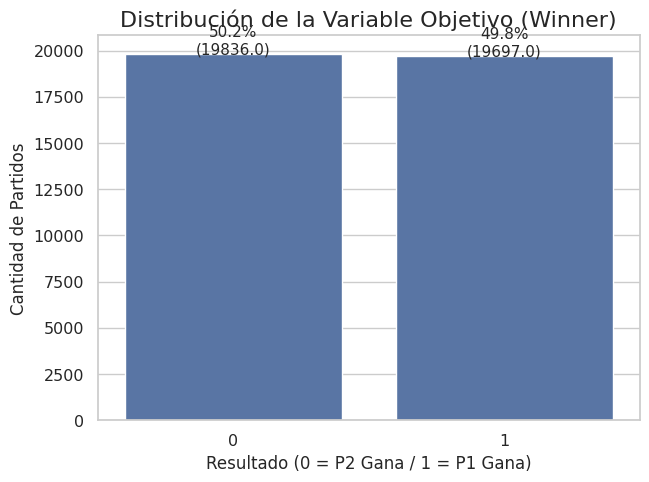

In [7]:
plt.figure(figsize=(7, 5))
sns.countplot(data=matches, x='winner')
plt.title('Distribución de la Variable Objetivo (Winner)', fontsize=16)
plt.xlabel('Resultado (0 = P2 Gana / 1 = P1 Gana)', fontsize=12)
plt.ylabel('Cantidad de Partidos', fontsize=12)

# Añadir etiquetas con los porcentajes
total = len(matches)
ax = plt.gca() # Get Current Axis
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height + 5,
            f'{height/total:.1%}\n({height})',
            ha="center", fontsize=11)
plt.show();

ANÁLISIS COMPLETO DE LA VARIABLE OBJETIVO (WINNER)


/tmp/ipykernel_37892/2143957629.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=matches_train, x='winner', palette=['#FF6B6B', '#4ECDC4'], ax=ax1)


<Axes: xlabel='winner', ylabel='count'>

Text(0.5, 1.0, 'Distribución de la Variable Objetivo (Winner)')

Text(0.5, 0, 'Resultado (0 = Player2 Gana / 1 = Player1 Gana)')

Text(0, 0.5, 'Cantidad de Partidos')

Text(0.0, 14029.0, '50.5%\n(13,979)')

Text(1.0, 13744.0, '49.5%\n(13,694)')

Text(0.5, 1.0, 'Balance de Clases')

(np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(1.0))

Text(0.1, 0.5, '\n📊 ESTADÍSTICAS DEL TARGET\n\nTotal de partidos: 27,673\n\n🎾 Player1 gana (winner=1):\n   • Cantidad: 13,694\n   • Porcentaje: 49.49%\n\n🎾 Player2 gana (winner=0):\n   • Cantidad: 13,979\n   • Porcentaje: 50.51%\n\n⚖️ Balance:\n   • Diferencia: 285\n   • Ratio: 1.02:1\n')

/tmp/ipykernel_37892/2143957629.py:77: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipykernel_37892/2143957629.py:77: UserWarning: Glyph 127934 (\N{TENNIS RACQUET AND BALL}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipykernel_37892/2143957629.py:77: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/home/sterry/miniconda/envs/problemslista1/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
/home/sterry/miniconda/envs/problemslista1/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127934 (\N{TENNIS RACQUET AND BALL}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
/home/sterry/miniconda/envs/problemslista1/lib/python3.10/site-packages/IPython/core

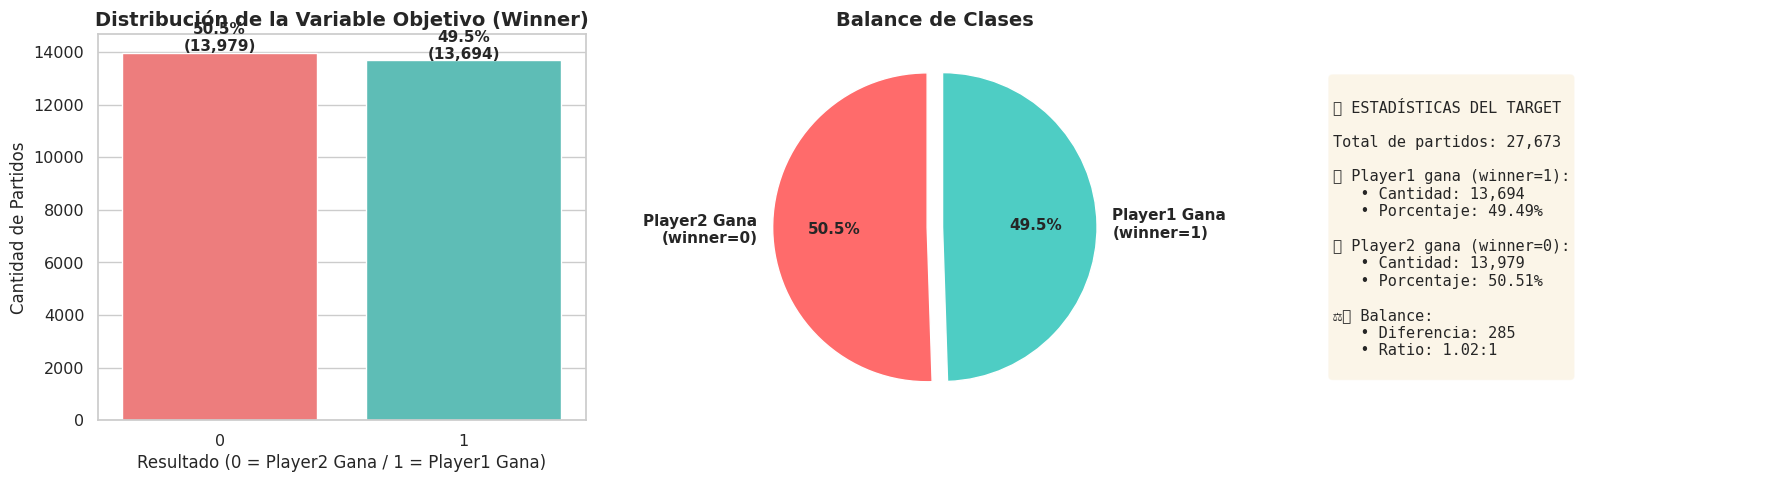


✅ El dataset está balanceado (aproximadamente 50%-50%)
   → No será necesario aplicar técnicas de balanceo de clases


In [8]:
# ============================================================================
# ANÁLISIS DE LA VARIABLE OBJETIVO: WINNER
# ============================================================================

print("="*80)
print("ANÁLISIS COMPLETO DE LA VARIABLE OBJETIVO (WINNER)")
print("="*80)

# 1. Gráfico de barras con distribución
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Subplot 1: Countplot
ax1 = axes[0]
sns.countplot(data=matches_train, x='winner', palette=['#FF6B6B', '#4ECDC4'], ax=ax1)
ax1.set_title('Distribución de la Variable Objetivo (Winner)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Resultado (0 = Player2 Gana / 1 = Player1 Gana)', fontsize=12)
ax1.set_ylabel('Cantidad de Partidos', fontsize=12)

# Añadir etiquetas con porcentajes
total = len(matches_train)
for p in ax1.patches:
    height = p.get_height()
    ax1.text(p.get_x() + p.get_width()/2.,
            height + 50,
            f'{height/total:.1%}\n({int(height):,})',
            ha="center", fontsize=11, fontweight='bold')

# Subplot 2: Pie Chart (para ver balance de clases)
ax2 = axes[1]
winner_counts = matches_train['winner'].value_counts()
colors_pie = ['#FF6B6B', '#4ECDC4']
explode = (0.05, 0.05)  # Separar ligeramente las porciones

wedges, texts, autotexts = ax2.pie(
    winner_counts.values, 
    labels=['Player2 Gana\n(winner=0)', 'Player1 Gana\n(winner=1)'],
    autopct='%1.1f%%',
    colors=colors_pie,
    explode=explode,
    startangle=90,
    textprops={'fontsize': 11, 'fontweight': 'bold'}
)

ax2.set_title('Balance de Clases', fontsize=14, fontweight='bold')

# Subplot 3: Estadísticas resumen
ax3 = axes[2]
ax3.axis('off')

# Calcular estadísticas
n_player1_wins = matches_train['winner'].sum()
n_player2_wins = len(matches_train) - n_player1_wins
pct_player1 = (n_player1_wins / len(matches_train)) * 100
pct_player2 = (n_player2_wins / len(matches_train)) * 100

stats_text = f"""
📊 ESTADÍSTICAS DEL TARGET

Total de partidos: {len(matches_train):,}

🎾 Player1 gana (winner=1):
   • Cantidad: {n_player1_wins:,}
   • Porcentaje: {pct_player1:.2f}%

🎾 Player2 gana (winner=0):
   • Cantidad: {n_player2_wins:,}
   • Porcentaje: {pct_player2:.2f}%

⚖️ Balance:
   • Diferencia: {abs(n_player1_wins - n_player2_wins):,}
   • Ratio: {max(pct_player1, pct_player2) / min(pct_player1, pct_player2):.2f}:1
"""

ax3.text(0.1, 0.5, stats_text, fontsize=11, verticalalignment='center',
         fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.show();

print("\n✅ El dataset está balanceado (aproximadamente 50%-50%)")
print("   → No será necesario aplicar técnicas de balanceo de clases")

/tmp/ipykernel_37892/2151687414.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_37892/2151687414.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_37892/2151687414.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_37892/2151687414.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_37892/2151687414.py:24: FutureW

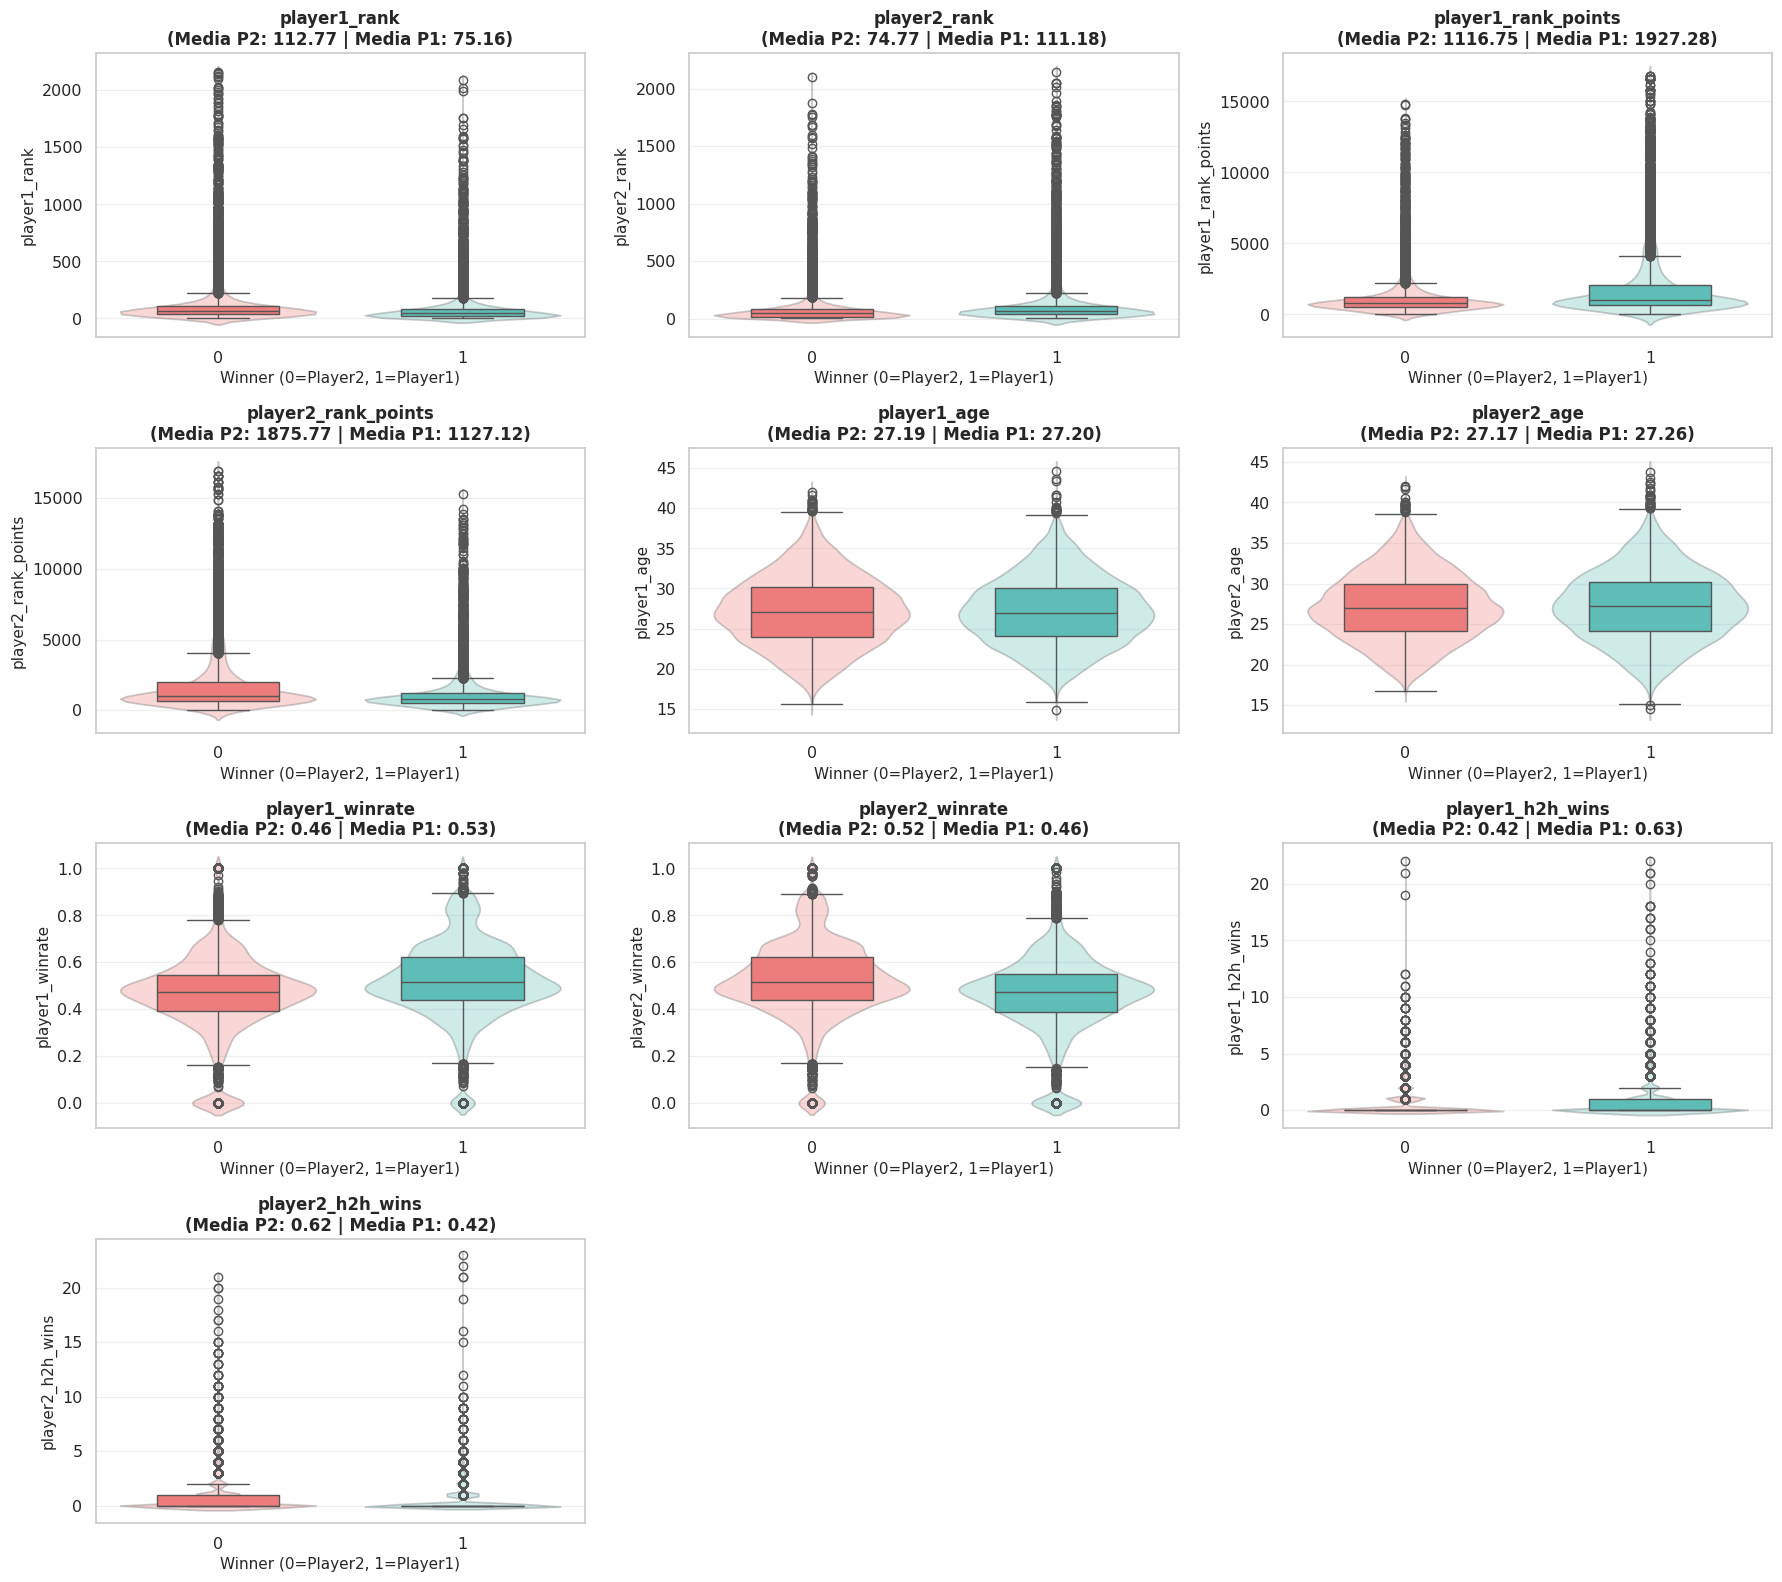

In [9]:
variables_clave = [
    'player1_rank', 'player2_rank',
    'player1_rank_points', 'player2_rank_points',
    'player1_age', 'player2_age',
    'player1_winrate', 'player2_winrate',
    'player1_h2h_wins', 'player2_h2h_wins'
]

# Filtrar solo las que existen en el dataset
variables_disponibles = [col for col in variables_clave if col in matches_train.columns]

# Calcular layout
n_vars = len(variables_disponibles)
n_cols = 3
n_rows = int(np.ceil(n_vars / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten() if n_vars > 1 else [axes]

for i, col in enumerate(variables_disponibles):
    ax = axes[i]
    
    # Boxplot con paleta de colores
    sns.boxplot(
        data=matches_train,
        x='winner',
        y=col,
        palette=['#FF6B6B', '#4ECDC4'],
        ax=ax,
        width=0.5
    )
    
    # Añadir violin plot superpuesto para ver distribución
    sns.violinplot(
        data=matches_train,
        x='winner',
        y=col,
        palette=['#FF6B6B', '#4ECDC4'],
        ax=ax,
        alpha=0.3,
        inner=None
    )
    
    # Calcular medias para cada grupo
    mean_0 = matches_train[matches_train['winner'] == 0][col].mean()
    mean_1 = matches_train[matches_train['winner'] == 1][col].mean()
    
    ax.set_title(f'{col}\n(Media P2: {mean_0:.2f} | Media P1: {mean_1:.2f})', 
                 fontsize=12, fontweight='bold')
    ax.set_xlabel('Winner (0=Player2, 1=Player1)', fontsize=11)
    ax.set_ylabel(col, fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')

# Ocultar ejes sobrantes
for j in range(n_vars, len(axes)):
    axes[j].axis('off')

plt.tight_layout();
plt.show();

In [10]:
columnas_numericas = matches.select_dtypes(include='number').columns.tolist()
columnas_categoricas = matches.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

print("\n✅ Columnas Numéricas:")
print(columnas_numericas)

print("\n✅ Columnas Categóricas:")
print(columnas_categoricas)


✅ Columnas Numéricas:
['draw_size', 'tourney_date', 'match_num', 'best_of', 'year', 'month', 'tourney_points', 'player1_ht', 'player1_age', 'player1_rank', 'player1_rank_points', 'player2_ht', 'player2_age', 'player2_rank', 'player2_rank_points', 'winner', 'player1_h2h_wins', 'player2_h2h_wins', 'player1_total_wins', 'player1_total_losses', 'player1_winrate', 'player1_ytd_wins', 'player1_ytd_losses', 'player1_ytd_winrate', 'player2_total_wins', 'player2_total_losses', 'player2_winrate', 'player2_ytd_wins', 'player2_ytd_losses', 'player2_ytd_winrate', 'player1_last10_wins', 'player1_last10_losses', 'player1_last10_winrate', 'player2_last10_wins', 'player2_last10_losses', 'player2_last10_winrate']

✅ Columnas Categóricas:
['tourney_name', 'surface', 'round', 'player1_entry', 'player1_name', 'player1_hand', 'player1_ioc', 'player2_entry', 'player2_name', 'player2_hand', 'player2_ioc']


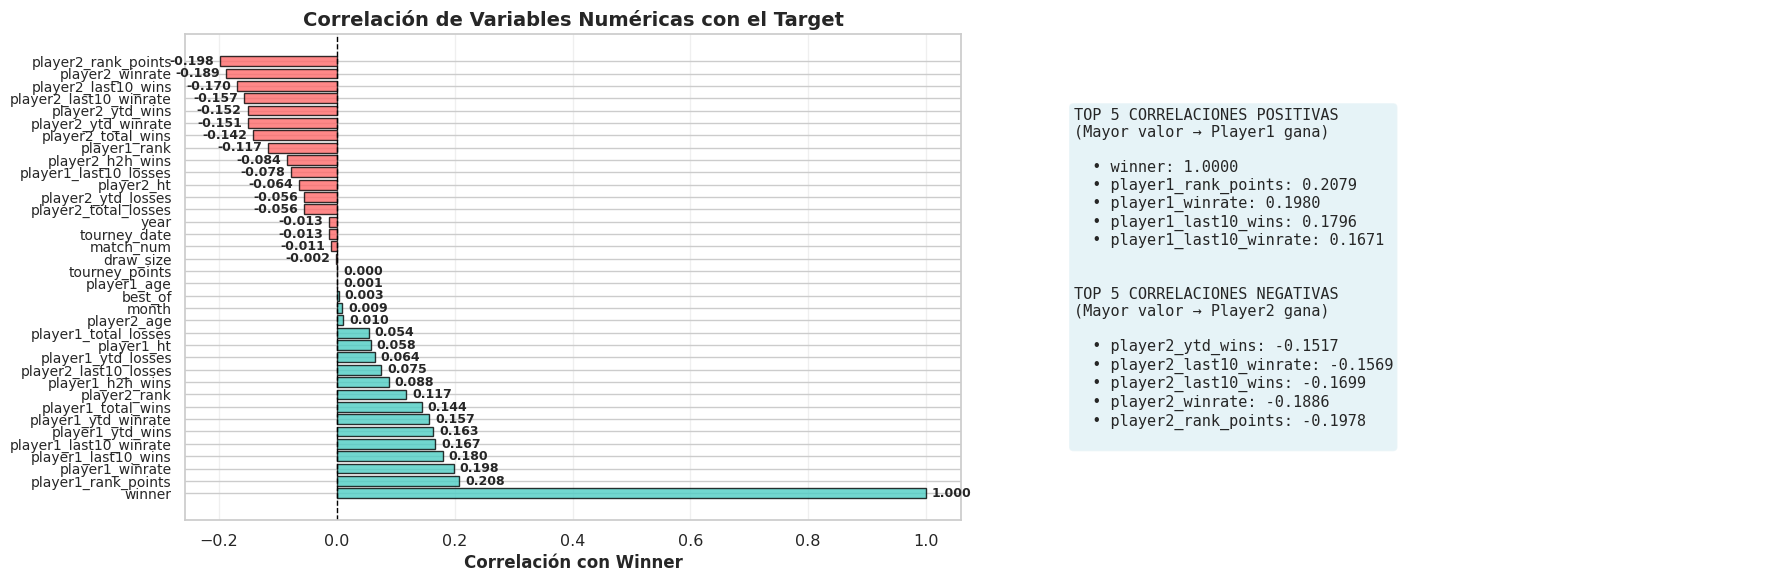

In [11]:
correlaciones = matches_train[columnas_numericas].corrwith(matches_train['winner']).sort_values(ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Subplot 1: Barplot de correlaciones
ax1 = axes[0]
colors_corr = ['#4ECDC4' if x > 0 else '#FF6B6B' for x in correlaciones.values]
bars = ax1.barh(range(len(correlaciones)), correlaciones.values, color=colors_corr, alpha=0.8, edgecolor='black')

ax1.set_yticks(range(len(correlaciones)))
ax1.set_yticklabels(correlaciones.index, fontsize=10)
ax1.set_xlabel('Correlación con Winner', fontsize=12, fontweight='bold')
ax1.set_title('Correlación de Variables Numéricas con el Target', fontsize=14, fontweight='bold')
ax1.axvline(x=0, color='black', linewidth=1, linestyle='--')
ax1.grid(True, alpha=0.3, axis='x')

# Añadir valores en las barras
for i, (bar, val) in enumerate(zip(bars, correlaciones.values)):
    ax1.text(val + (0.01 if val > 0 else -0.01), i, f'{val:.3f}',
             ha='left' if val > 0 else 'right', va='center', fontsize=9, fontweight='bold')

# Subplot 2: Tabla con top correlaciones
ax2 = axes[1]
ax2.axis('off')

# Crear tabla con top correlaciones positivas y negativas
top_positivas = correlaciones.head(5)
top_negativas = correlaciones.tail(5)

tabla_text = "TOP 5 CORRELACIONES POSITIVAS\n"
tabla_text += "(Mayor valor → Player1 gana)\n\n"
for var, corr in top_positivas.items():
    tabla_text += f"  • {var}: {corr:.4f}\n"

tabla_text += "\n\nTOP 5 CORRELACIONES NEGATIVAS\n"
tabla_text += "(Mayor valor → Player2 gana)\n\n"
for var, corr in top_negativas.items():
    tabla_text += f"  • {var}: {corr:.4f}\n";

ax2.text(0.1, 0.5, tabla_text, fontsize=11, verticalalignment='center',
         fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3));

plt.tight_layout();
plt.show();

#### Variables explicativas

Primero dividimos las variables en función de su tipo (Categóricas o numércias)

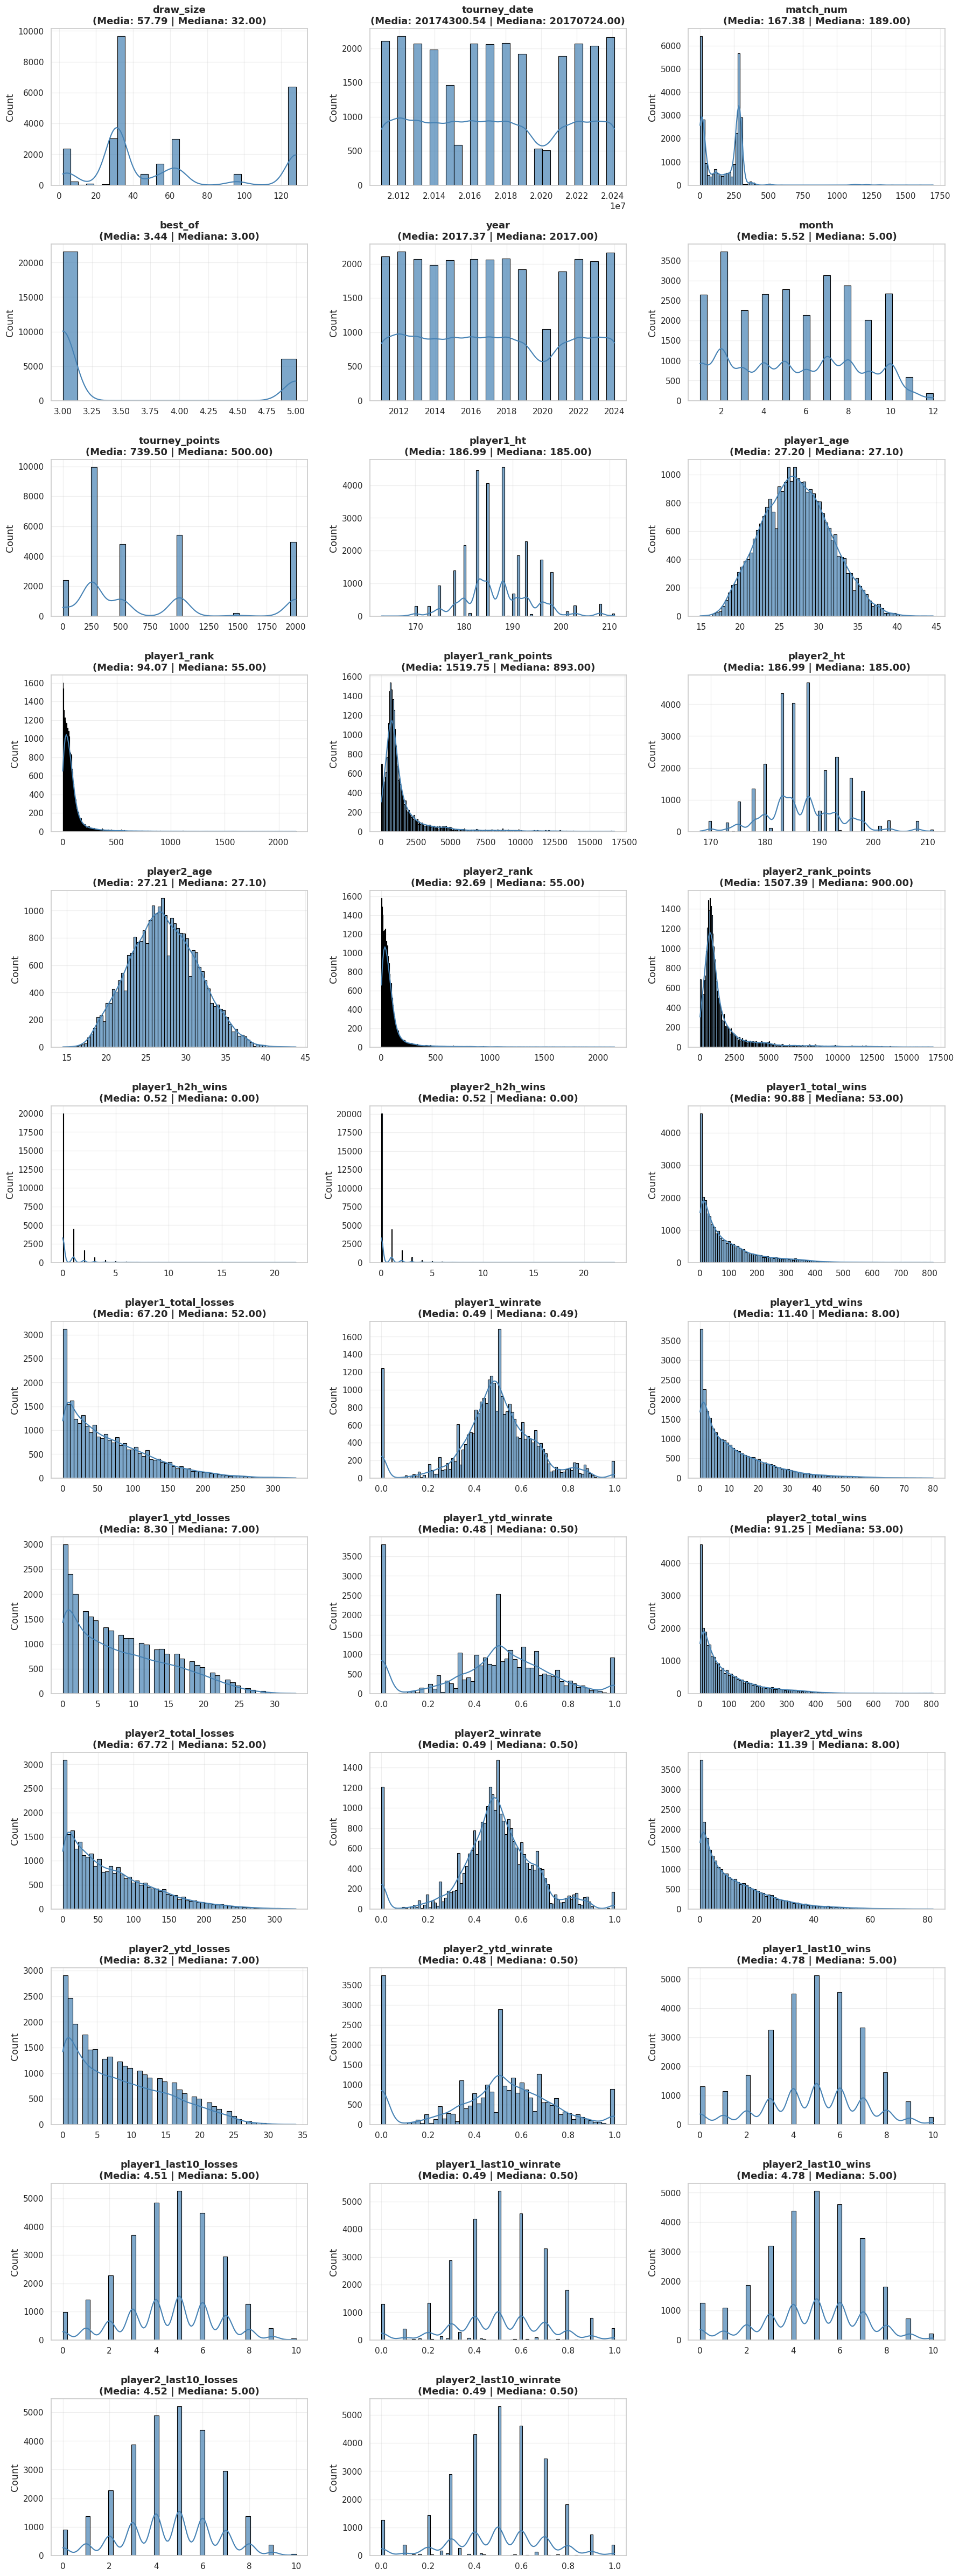

In [12]:
columnas_numericas_sin_target = [col for col in columnas_numericas if col != 'winner']

# Calcular layout óptimo para variables numéricas
n_num_vars = len(columnas_numericas_sin_target)
n_cols = 3  # 3 columnas por fila
n_rows = int(np.ceil(n_num_vars / n_cols))

# Crear figura con tamaño proporcional al número de gráficos
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten() if n_num_vars > 1 else [axes]

for i, col in enumerate(columnas_numericas_sin_target):
    ax = axes[i]
    
    # Histograma con KDE
    sns.histplot(
        data=matches_train,
        x=col,
        kde=True,
        ax=ax,
        stat='count',
        alpha=0.7,
        edgecolor="black",
        linewidth=0.8,
        color='steelblue'
    )
    
    # Añadir estadísticas básicas al título
    mean_val = matches_train[col].mean()
    median_val = matches_train[col].median()
    
    ax.set_title(f'{col}\n(Media: {mean_val:.2f} | Mediana: {median_val:.2f})', 
                 fontsize=13, fontweight='bold')
    ax.set_xlabel('')
    ax.tick_params(axis='both', which='major', labelsize=11)
    ax.grid(True, alpha=0.3)

# Ocultar ejes sobrantes
for j in range(n_num_vars, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show();

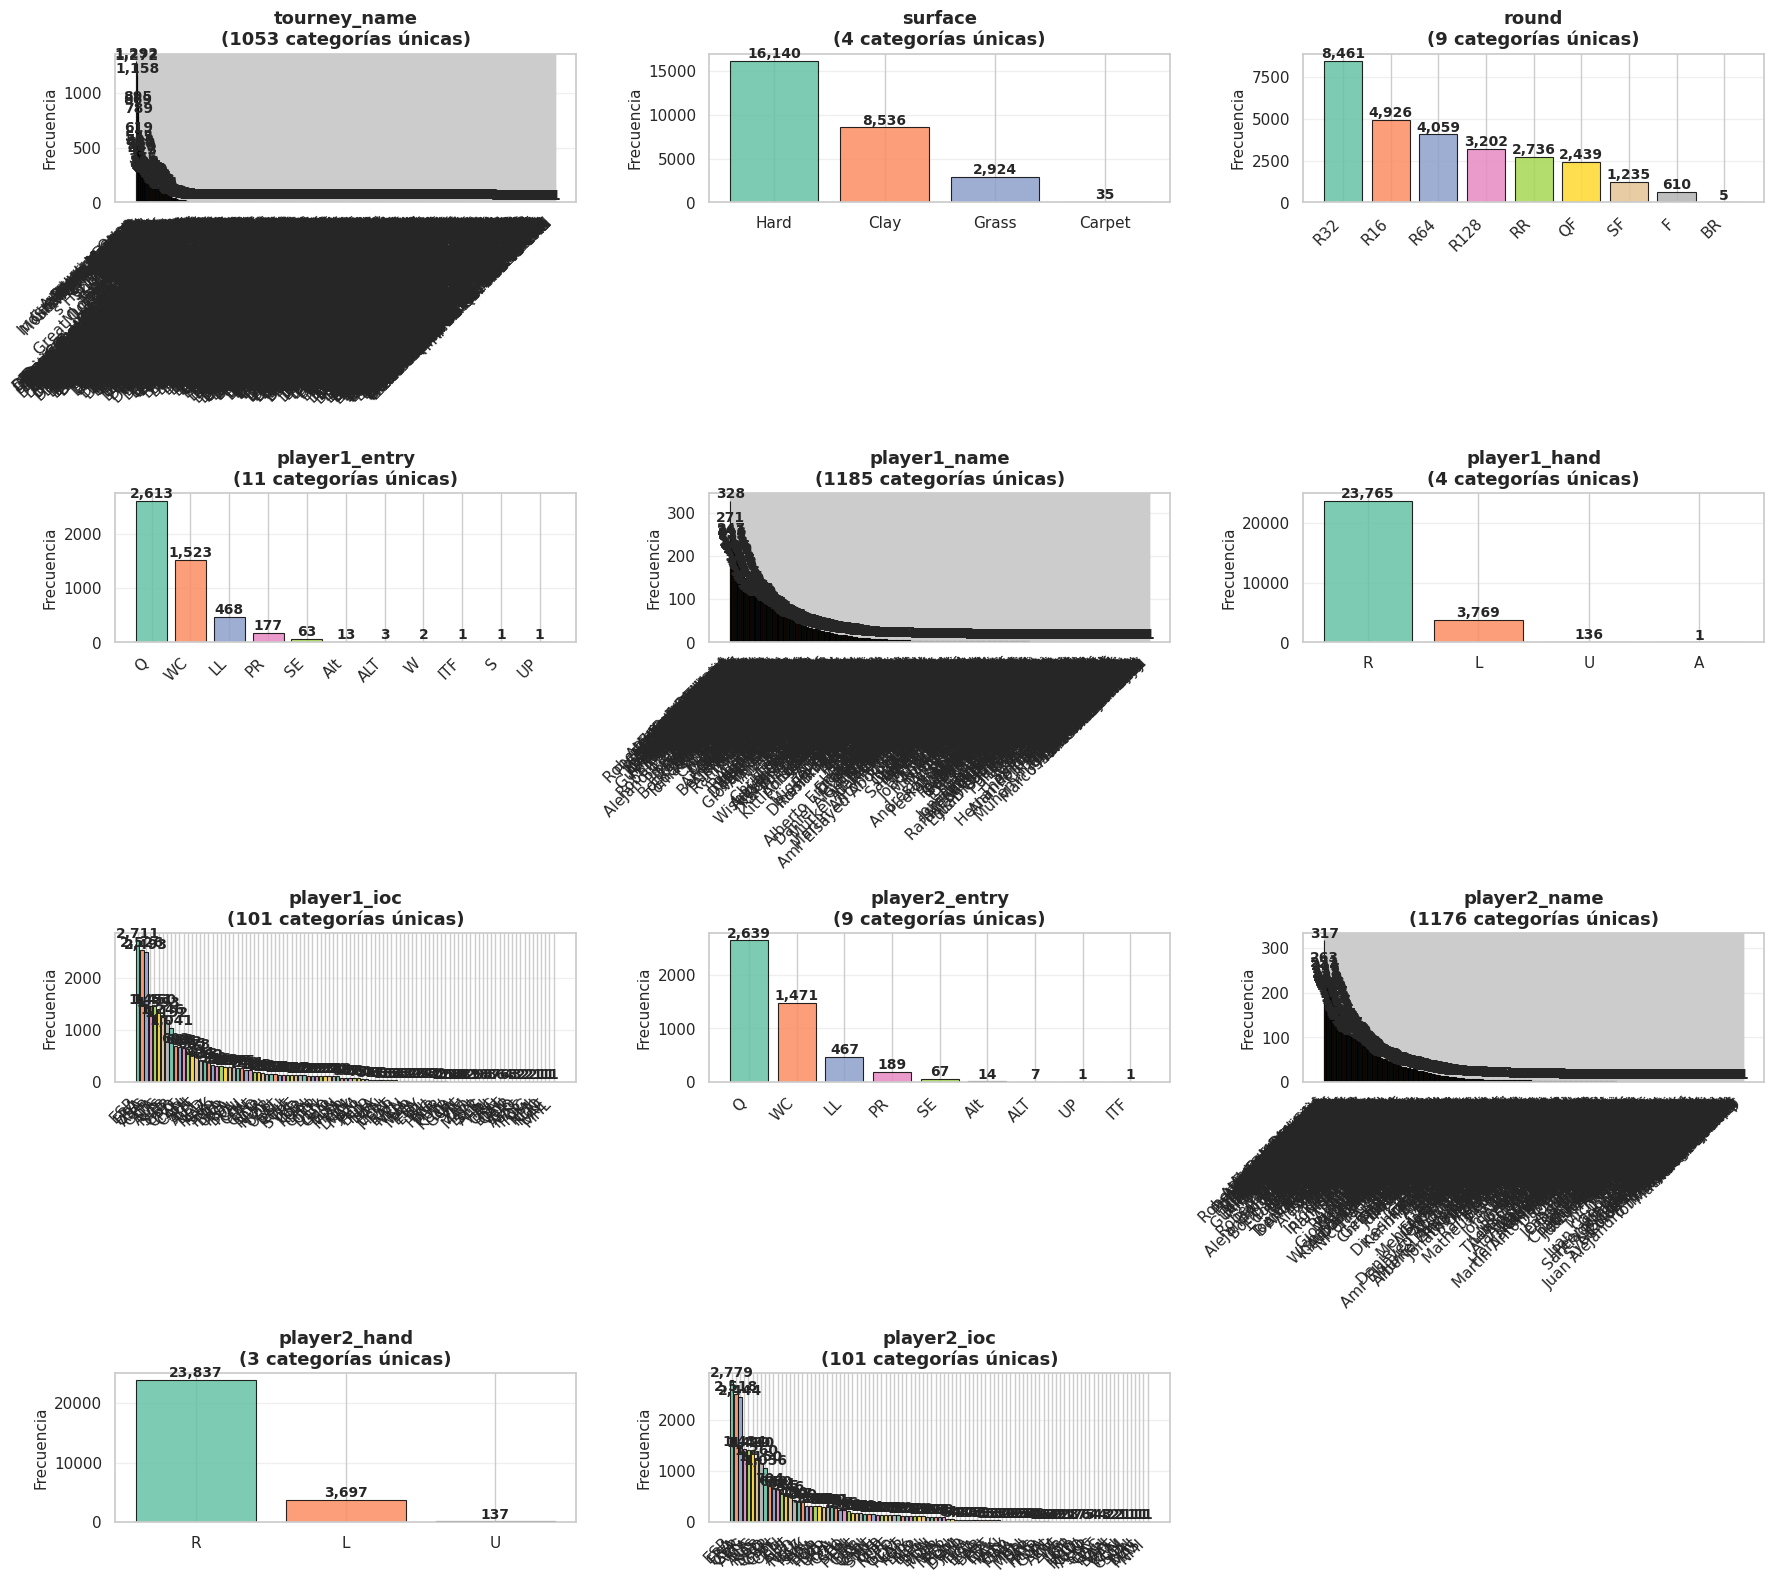

In [13]:
n_cat_vars = len(columnas_categoricas)
n_cols = 3  # 3 columnas por fila
n_rows = int(np.ceil(n_cat_vars / n_cols))

# Crear figura con tamaño proporcional al número de gráficos
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten() if n_cat_vars > 1 else [axes]

for i, col in enumerate(columnas_categoricas):
    ax = axes[i]
    
    # Contar frecuencias
    vc = matches_train[col].value_counts()
    categories = vc.index.astype(str)
    counts = vc.values
    
    # Paleta de colores
    colors = sns.color_palette("Set2", n_colors=len(categories))
    
    # Gráfico de barras
    bars = ax.bar(categories, counts, color=colors, alpha=0.85, 
                   edgecolor='black', linewidth=0.8)
    
    # Añadir valores encima de las barras
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Título con número de categorías
    ax.set_title(f'{col}\n({len(categories)} categorías únicas)', 
                 fontsize=13, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('Frecuencia', fontsize=11)
    ax.tick_params(axis='both', which='major', labelsize=11)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Rotar etiquetas si hay muchas categorías
    if len(categories) > 5:
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    elif len(categories) > 10:
        plt.setp(ax.get_xticklabels(), rotation=90, ha='right')

# Ocultar ejes sobrantes
for j in range(n_cat_vars, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show();

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, r2_score
import numpy as np

# --- 1. Definir Features (X) y Target (y) ---
try:
    # Intenta usar columnas de ejemplo comunes
    feature_cols = [
    'draw_size', 'best_of', 'tourney_points', 
    'player1_ht', 'player1_age', 'player1_rank', 'player1_rank_points', 
    'player2_ht', 'player2_age', 'player2_rank', 'player2_rank_points', 
    'player1_h2h_wins', 'player2_h2h_wins', 
    'player1_total_wins', 'player1_total_losses', 'player1_winrate', 
    'player1_ytd_wins', 'player1_ytd_losses', 'player1_ytd_winrate', 
    'player2_total_wins', 'player2_total_losses', 'player2_winrate', 
    'player2_ytd_wins', 'player2_ytd_losses', 'player2_ytd_winrate', 
    'player1_last10_wins', 'player1_last10_losses', 'player1_last10_winrate', 
    'player2_last10_wins', 'player2_last10_losses', 'player2_last10_winrate'
]
    target_col = 'winner'
    
    # Asigna X e y desde tu DataFrame 'matches'
    # Seleccionamos solo las columnas que vamos a usar
    cols_to_use = feature_cols + [target_col]
    temp_df = matches[cols_to_use]

except KeyError as e:
    print(f"Error: No se encontró la columna {e}.")
    print("Por favor, edita las listas 'feature_cols' y 'target_col' en el código.")
    raise e
except NameError:
    print("Error: No se encontró la variable 'matches'.")
    raise

# --- 2. Eliminar NaNs ---
# StandardScaler no puede manejar valores NaN.
# Eliminamos cualquier fila que tenga AL MENOS un valor NaN en las columnas seleccionadas.

original_count = len(temp_df)
temp_df = temp_df.dropna() # <-- ¡AQUÍ ESTÁ LA SOLUCIÓN!
new_count = len(temp_df)

print(f"Limpiando datos: Se eliminaron {original_count - new_count} filas con valores NaN.")
print(f"Total de muestras restantes para el modelo: {new_count}")
print("-" * 40)

# Volvemos a separar X e y, ahora limpios y sincronizados
X = temp_df[feature_cols]
y = temp_df[target_col]

# --- 3. Escalar las Features ---
# Ahora esto funcionará porque no hay NaNs
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- 4. Dividir los datos (70% train, 30% test) ---
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, 
                                                    test_size=0.30, 
                                                    random_state=42, 
                                                    stratify=y)

print(f"Datos divididos:")
print(f" - Muestras de entrenamiento: {len(X_train)}")
print(f" - Muestras de prueba:        {len(X_test)}")
print("-" * 40)

# --- 5. Entrenar el Modelo de Regresión Logística ---
# Aumentamos max_iter; con muchas features, el modelo puede necesitar
# más iteraciones para converger y evitar un Warning.
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

print("Modelo de Regresión Logística entrenado.")
print("-" * 40)

# --- 6. Evaluar el Modelo ---
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
baseline_accuracy = y_test.value_counts(normalize=True).max()

# --- 7. Mostrar Resultados ---
print("--- Resultados de la Evaluación ---")
print(f"Precisión (Accuracy):        {accuracy:.4f} (o {accuracy * 100:.2f}%)")
print(f"Línea Base ('Azar'):         {baseline_accuracy:.4f} (o {baseline_accuracy * 100:.2f}%)")
print(f"\nPuntuación R^2 (solicitada): {r2:.4f}")
print("-" * 40)

# Conclusión
if accuracy > baseline_accuracy:
    print(f"✅ Conclusión: El modelo ({accuracy*100:.2f}%) es MEJOR que la línea base/azar ({baseline_accuracy*100:.2f}%).")
else:
    print(f"❌ Conclusión: El modelo ({accuracy*100:.2f}%) NO es mejor que la línea base/azar ({baseline_accuracy*100:.2f}%).")

Limpiando datos: Se eliminaron 1354 filas con valores NaN.
Total de muestras restantes para el modelo: 38179
----------------------------------------
Datos divididos:
 - Muestras de entrenamiento: 26725
 - Muestras de prueba:        11454
----------------------------------------


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


Modelo de Regresión Logística entrenado.
----------------------------------------
--- Resultados de la Evaluación ---
Precisión (Accuracy):        0.6702 (o 67.02%)
Línea Base ('Azar'):         0.5018 (o 50.18%)

Puntuación R^2 (solicitada): -0.3194
----------------------------------------
✅ Conclusión: El modelo (67.02%) es MEJOR que la línea base/azar (50.18%).
